In [1]:
utils_path = "../utils"
models_path = "../models"
data_path = "../data/celebs_105"

import sys
import os
sys.path.insert(1, utils_path)
sys.path.insert(2, models_path)

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import numpy as np

from comet_ml import Experiment

import config

import time 
import copy
import random
from tqdm.notebook import trange, tqdm

import torchvision

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torchvision.transforms as transformss

from MBNV3 import MobileNetV3
from MBNV3CBAM import MobileNetV3CBAM

from dataloader import mixedSets
from functions import train, evaluate, confusion, unzip_files, unzip

In [2]:
#Initialising GereralTorch class

#Setting the experiment with the API key stored in config.py
experiment = Experiment(project_name = "Celebs_105_MobileNet", workspace = "leothesouthafrican", api_key = config.api_key)

#Report multiple hyperparameters using a dictionary
hyper_params = {
    'learning_rate': 0.001,
    'epochs': 200,
    'batch_size': 32,
    'image_size': 112,
    'image_channels': 3,
    'output_size': len(os.listdir(data_path)) - 1,
    'num_layers': 'na',
    'train_val_test_split': [0.8, 0.1, 0.1],
    'device': 'mps',
    'model_name': 'MobileNet3 with CBAM inserted instead of SE starting from a fresh model with no preloaded weights.',
    'criterion': 'CrossEntropyLoss',
    'optimizer': 'Adam',
    'dataset': 'Celebrities 20',
    'best_model_path': 'output/MN3LCB_celebs105.pt',
    'loaded_model_path': 'output/MN3LCB_celebs20.pt',
    'comet_exp': experiment,
    'save_at_end': True,
}

print(f'Output Size: {hyper_params["output_size"]}')

#Setting the device
device = torch.device(hyper_params['device'])

#checking if the model is to be a loaded one and if so loading it
if hyper_params['loaded_model_path']:
    state_dict = torch.load(hyper_params['loaded_model_path']) #Loading the state dict
    model = MobileNetV3CBAM(mode='large') #Loading the model as a backbone
    model.load_state_dict(state_dict, strict= True) #Loading the state dict into the model
    print('Model Loaded')
else:
    # Loading a fresh model
    model = MobileNetV3CBAM(mode='large')

#passing the model to the device
model.to(device)

# Setting the loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device) #Setting the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=hyper_params['learning_rate']) #Setting the optimizer

# Logging the hyperparameters to comet
experiment.log_parameters(hyper_params)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/leothesouthafrican/celebs-20-mobilenet/00df59fb82f1427bbedb2360620b854e



Output Size: 20


In [3]:
#defining transforms

train_transform = transforms.Compose([
                transforms.Resize((hyper_params['image_size'],hyper_params['image_size'])),
                transforms.ToTensor(),
                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
                transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                transforms.RandomCrop(hyper_params['image_size'], padding=2)], p=0.2),
                transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.8,1.2)),
                transforms.RandomRotation(15),
                transforms.RandomHorizontalFlip(0.15),
                transforms.RandomVerticalFlip(0.1),
                transforms.RandomErasing(0.1),
            ])

test_transform = transforms.Compose([
                transforms.Resize((hyper_params['image_size'],hyper_params['image_size'])),
                transforms.ToTensor(),
                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
            ])

In [4]:
# Creating the dataset
train_dataset = mixedSets(data_path, train_transform, hyper_params['train_val_test_split']).get_train_dataset()
val_dataset = mixedSets(data_path, test_transform, hyper_params['train_val_test_split']).get_val_dataset()
test_dataset = mixedSets(data_path, test_transform, hyper_params['train_val_test_split']).get_test_dataset()

# Creating the dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                            batch_size=hyper_params['batch_size'],
                                            shuffle=True,
                                            num_workers=1)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                            batch_size=hyper_params['batch_size'],
                                            shuffle=True,
                                            num_workers=1)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=hyper_params['batch_size'],
                                            shuffle=True,
                                            num_workers=1)


Train dataset size: 2642, with 20 classes
Val dataset size: 331, with 20 classes
Test dataset size: 331, with 20 classes


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


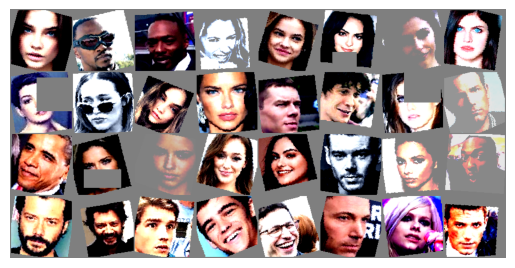

tensor(18) tensor(7) tensor(7) tensor(4)


In [5]:
#display random images from the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #drop axis labels
    plt.axis('off')
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(4)))

In [6]:
with experiment.train():
    train(model, criterion, optimizer, hyper_params, train_loader, val_loader)

Begin training...


100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


Best model saved at epoch 2 with accuracy 0.0634 and loss inf.
	Train Loss: 2.990 | Train Acc: 0.00%
Epoch: 02 | Epoch Time: 0m 34s
	 Val. Loss: inf |  Val. Acc: 6.34%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


Best model saved at epoch 3 with accuracy 0.1118 and loss 2.922.
	Train Loss: 3.044 | Train Acc: 5.56%
Epoch: 03 | Epoch Time: 0m 29s
	 Val. Loss: 2.922 |  Val. Acc: 11.18%


100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


	Train Loss: 2.696 | Train Acc: 22.22%
Epoch: 04 | Epoch Time: 0m 29s
	 Val. Loss: 2.875 |  Val. Acc: 9.06%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


Best model saved at epoch 5 with accuracy 0.1208 and loss 2.7115.
	Train Loss: 2.970 | Train Acc: 11.11%
Epoch: 05 | Epoch Time: 0m 29s
	 Val. Loss: 2.711 |  Val. Acc: 12.08%


100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


Best model saved at epoch 6 with accuracy 0.1511 and loss 2.6703.
	Train Loss: 2.873 | Train Acc: 5.56%
Epoch: 06 | Epoch Time: 0m 29s
	 Val. Loss: 2.670 |  Val. Acc: 15.11%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


Best model saved at epoch 7 with accuracy 0.1813 and loss 2.5623.
	Train Loss: 2.571 | Train Acc: 22.22%
Epoch: 07 | Epoch Time: 0m 30s
	 Val. Loss: 2.562 |  Val. Acc: 18.13%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 2.819 | Train Acc: 11.11%
Epoch: 08 | Epoch Time: 0m 29s
	 Val. Loss: 2.670 |  Val. Acc: 17.52%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 2.982 | Train Acc: 5.56%
Epoch: 09 | Epoch Time: 0m 32s
	 Val. Loss: 2.671 |  Val. Acc: 15.41%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 2.726 | Train Acc: 5.56%
Epoch: 10 | Epoch Time: 0m 33s
	 Val. Loss: 2.641 |  Val. Acc: 16.31%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 2.856 | Train Acc: 16.67%
Epoch: 11 | Epoch Time: 0m 33s
	 Val. Loss: 2.535 |  Val. Acc: 17.52%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


Best model saved at epoch 12 with accuracy 0.1964 and loss 2.5097.
	Train Loss: 2.659 | Train Acc: 27.78%
Epoch: 12 | Epoch Time: 0m 33s
	 Val. Loss: 2.510 |  Val. Acc: 19.64%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


Best model saved at epoch 13 with accuracy 0.2115 and loss 2.427.
	Train Loss: 2.890 | Train Acc: 16.67%
Epoch: 13 | Epoch Time: 0m 32s
	 Val. Loss: 2.427 |  Val. Acc: 21.15%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 2.375 | Train Acc: 38.89%
Epoch: 14 | Epoch Time: 0m 31s
	 Val. Loss: 2.462 |  Val. Acc: 19.64%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


Best model saved at epoch 15 with accuracy 0.2477 and loss 2.4025.
	Train Loss: 2.329 | Train Acc: 33.33%
Epoch: 15 | Epoch Time: 0m 31s
	 Val. Loss: 2.403 |  Val. Acc: 24.77%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 2.507 | Train Acc: 16.67%
Epoch: 16 | Epoch Time: 0m 31s
	 Val. Loss: 2.413 |  Val. Acc: 22.36%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 2.254 | Train Acc: 33.33%
Epoch: 17 | Epoch Time: 0m 30s
	 Val. Loss: 2.396 |  Val. Acc: 24.47%


100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


Best model saved at epoch 18 with accuracy 0.2689 and loss 2.2622.
	Train Loss: 2.377 | Train Acc: 22.22%
Epoch: 18 | Epoch Time: 0m 30s
	 Val. Loss: 2.262 |  Val. Acc: 26.89%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 2.505 | Train Acc: 22.22%
Epoch: 19 | Epoch Time: 0m 29s
	 Val. Loss: 2.348 |  Val. Acc: 22.36%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 2.109 | Train Acc: 22.22%
Epoch: 20 | Epoch Time: 0m 29s
	 Val. Loss: 2.313 |  Val. Acc: 26.59%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 2.410 | Train Acc: 33.33%
Epoch: 21 | Epoch Time: 0m 29s
	 Val. Loss: 2.304 |  Val. Acc: 25.08%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 2.547 | Train Acc: 5.56%
Epoch: 22 | Epoch Time: 0m 29s
	 Val. Loss: 2.315 |  Val. Acc: 24.47%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 2.643 | Train Acc: 38.89%
Epoch: 23 | Epoch Time: 0m 29s
	 Val. Loss: 2.409 |  Val. Acc: 22.96%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


Best model saved at epoch 24 with accuracy 0.3565 and loss 2.086.
	Train Loss: 2.369 | Train Acc: 11.11%
Epoch: 24 | Epoch Time: 0m 29s
	 Val. Loss: 2.086 |  Val. Acc: 35.65%


100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


	Train Loss: 2.139 | Train Acc: 27.78%
Epoch: 25 | Epoch Time: 0m 29s
	 Val. Loss: 2.159 |  Val. Acc: 30.51%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 2.308 | Train Acc: 38.89%
Epoch: 26 | Epoch Time: 0m 29s
	 Val. Loss: 2.164 |  Val. Acc: 27.49%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 1.943 | Train Acc: 38.89%
Epoch: 27 | Epoch Time: 0m 29s
	 Val. Loss: 2.102 |  Val. Acc: 32.02%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 2.238 | Train Acc: 27.78%
Epoch: 28 | Epoch Time: 0m 29s
	 Val. Loss: 2.071 |  Val. Acc: 33.84%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


Best model saved at epoch 29 with accuracy 0.4139 and loss 1.9181.
	Train Loss: 2.659 | Train Acc: 11.11%
Epoch: 29 | Epoch Time: 0m 29s
	 Val. Loss: 1.918 |  Val. Acc: 41.39%


100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


	Train Loss: 2.247 | Train Acc: 38.89%
Epoch: 30 | Epoch Time: 0m 29s
	 Val. Loss: 2.063 |  Val. Acc: 30.51%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 1.627 | Train Acc: 44.44%
Epoch: 31 | Epoch Time: 0m 29s
	 Val. Loss: 2.080 |  Val. Acc: 30.51%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 2.230 | Train Acc: 16.67%
Epoch: 32 | Epoch Time: 0m 29s
	 Val. Loss: 1.924 |  Val. Acc: 36.56%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 2.599 | Train Acc: 22.22%
Epoch: 33 | Epoch Time: 0m 29s
	 Val. Loss: 1.995 |  Val. Acc: 35.35%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 2.241 | Train Acc: 27.78%
Epoch: 34 | Epoch Time: 0m 30s
	 Val. Loss: 1.827 |  Val. Acc: 38.97%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 1.728 | Train Acc: 50.00%
Epoch: 35 | Epoch Time: 0m 29s
	 Val. Loss: 2.019 |  Val. Acc: 32.33%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 1.799 | Train Acc: 44.44%
Epoch: 36 | Epoch Time: 0m 29s
	 Val. Loss: 1.903 |  Val. Acc: 39.58%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 2.117 | Train Acc: 27.78%
Epoch: 37 | Epoch Time: 0m 29s
	 Val. Loss: 1.762 |  Val. Acc: 38.97%


100%|██████████| 11/11 [00:06<00:00,  1.71it/s]


	Train Loss: 2.462 | Train Acc: 33.33%
Epoch: 38 | Epoch Time: 0m 29s
	 Val. Loss: 1.717 |  Val. Acc: 40.18%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 1.763 | Train Acc: 33.33%
Epoch: 39 | Epoch Time: 0m 29s
	 Val. Loss: 1.816 |  Val. Acc: 40.48%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


Best model saved at epoch 40 with accuracy 0.4199 and loss 1.7062.
	Train Loss: 1.991 | Train Acc: 38.89%
Epoch: 40 | Epoch Time: 0m 29s
	 Val. Loss: 1.706 |  Val. Acc: 41.99%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 2.008 | Train Acc: 33.33%
Epoch: 41 | Epoch Time: 0m 29s
	 Val. Loss: 1.799 |  Val. Acc: 41.39%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 2.154 | Train Acc: 27.78%
Epoch: 42 | Epoch Time: 0m 29s
	 Val. Loss: 1.751 |  Val. Acc: 36.86%


100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


Best model saved at epoch 43 with accuracy 0.435 and loss 1.6927.
	Train Loss: 1.817 | Train Acc: 38.89%
Epoch: 43 | Epoch Time: 0m 29s
	 Val. Loss: 1.693 |  Val. Acc: 43.50%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


Best model saved at epoch 44 with accuracy 0.4834 and loss 1.6294.
	Train Loss: 1.309 | Train Acc: 55.56%
Epoch: 44 | Epoch Time: 0m 29s
	 Val. Loss: 1.629 |  Val. Acc: 48.34%


100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


	Train Loss: 2.142 | Train Acc: 33.33%
Epoch: 45 | Epoch Time: 0m 29s
	 Val. Loss: 1.665 |  Val. Acc: 46.53%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 1.886 | Train Acc: 38.89%
Epoch: 46 | Epoch Time: 0m 29s
	 Val. Loss: 1.647 |  Val. Acc: 45.92%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 1.728 | Train Acc: 44.44%
Epoch: 47 | Epoch Time: 0m 29s
	 Val. Loss: 1.715 |  Val. Acc: 45.62%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 2.157 | Train Acc: 50.00%
Epoch: 48 | Epoch Time: 0m 29s
	 Val. Loss: 1.569 |  Val. Acc: 45.62%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


Best model saved at epoch 49 with accuracy 0.4955 and loss 1.5702.
	Train Loss: 1.366 | Train Acc: 66.67%
Epoch: 49 | Epoch Time: 0m 29s
	 Val. Loss: 1.570 |  Val. Acc: 49.55%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 1.463 | Train Acc: 50.00%
Epoch: 50 | Epoch Time: 0m 29s
	 Val. Loss: 1.550 |  Val. Acc: 49.55%


100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


	Train Loss: 1.845 | Train Acc: 33.33%
Epoch: 51 | Epoch Time: 0m 29s
	 Val. Loss: 1.551 |  Val. Acc: 48.94%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 1.583 | Train Acc: 61.11%
Epoch: 52 | Epoch Time: 0m 29s
	 Val. Loss: 1.692 |  Val. Acc: 46.22%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


Best model saved at epoch 53 with accuracy 0.5227 and loss 1.5961.
	Train Loss: 1.634 | Train Acc: 27.78%
Epoch: 53 | Epoch Time: 0m 29s
	 Val. Loss: 1.596 |  Val. Acc: 52.27%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 2.730 | Train Acc: 22.22%
Epoch: 54 | Epoch Time: 0m 29s
	 Val. Loss: 1.642 |  Val. Acc: 46.53%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 1.327 | Train Acc: 61.11%
Epoch: 55 | Epoch Time: 0m 29s
	 Val. Loss: 1.375 |  Val. Acc: 51.96%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 1.701 | Train Acc: 50.00%
Epoch: 56 | Epoch Time: 0m 29s
	 Val. Loss: 1.434 |  Val. Acc: 49.55%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 1.632 | Train Acc: 38.89%
Epoch: 57 | Epoch Time: 0m 29s
	 Val. Loss: 1.488 |  Val. Acc: 48.64%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 1.206 | Train Acc: 55.56%
Epoch: 58 | Epoch Time: 0m 29s
	 Val. Loss: 1.513 |  Val. Acc: 51.06%


100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


Best model saved at epoch 59 with accuracy 0.5498 and loss 1.3888.
	Train Loss: 1.089 | Train Acc: 61.11%
Epoch: 59 | Epoch Time: 0m 29s
	 Val. Loss: 1.389 |  Val. Acc: 54.98%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 1.853 | Train Acc: 27.78%
Epoch: 60 | Epoch Time: 0m 29s
	 Val. Loss: 1.439 |  Val. Acc: 51.36%


100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


	Train Loss: 1.340 | Train Acc: 61.11%
Epoch: 61 | Epoch Time: 0m 29s
	 Val. Loss: 1.423 |  Val. Acc: 54.68%


100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


	Train Loss: 1.296 | Train Acc: 55.56%
Epoch: 62 | Epoch Time: 0m 29s
	 Val. Loss: 1.466 |  Val. Acc: 51.06%


100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


	Train Loss: 1.510 | Train Acc: 55.56%
Epoch: 63 | Epoch Time: 0m 29s
	 Val. Loss: 1.366 |  Val. Acc: 53.78%


100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


	Train Loss: 1.136 | Train Acc: 66.67%
Epoch: 64 | Epoch Time: 0m 29s
	 Val. Loss: 1.436 |  Val. Acc: 54.68%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


Best model saved at epoch 65 with accuracy 0.5891 and loss 1.2183.
	Train Loss: 1.244 | Train Acc: 50.00%
Epoch: 65 | Epoch Time: 0m 29s
	 Val. Loss: 1.218 |  Val. Acc: 58.91%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 1.154 | Train Acc: 66.67%
Epoch: 66 | Epoch Time: 0m 29s
	 Val. Loss: 1.423 |  Val. Acc: 53.78%


100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


	Train Loss: 1.941 | Train Acc: 33.33%
Epoch: 67 | Epoch Time: 0m 29s
	 Val. Loss: 1.227 |  Val. Acc: 58.01%


100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


	Train Loss: 1.635 | Train Acc: 50.00%
Epoch: 68 | Epoch Time: 0m 29s
	 Val. Loss: 1.339 |  Val. Acc: 52.27%


100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


	Train Loss: 1.291 | Train Acc: 44.44%
Epoch: 69 | Epoch Time: 0m 28s
	 Val. Loss: 1.340 |  Val. Acc: 54.38%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


Best model saved at epoch 70 with accuracy 0.5921 and loss 1.3372.
	Train Loss: 1.447 | Train Acc: 44.44%
Epoch: 70 | Epoch Time: 0m 29s
	 Val. Loss: 1.337 |  Val. Acc: 59.21%


100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


	Train Loss: 1.664 | Train Acc: 50.00%
Epoch: 71 | Epoch Time: 0m 29s
	 Val. Loss: 1.555 |  Val. Acc: 53.17%


100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


	Train Loss: 1.194 | Train Acc: 66.67%
Epoch: 72 | Epoch Time: 0m 29s
	 Val. Loss: 1.266 |  Val. Acc: 55.89%


100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


Best model saved at epoch 73 with accuracy 0.6012 and loss 1.2844.
	Train Loss: 1.354 | Train Acc: 44.44%
Epoch: 73 | Epoch Time: 0m 29s
	 Val. Loss: 1.284 |  Val. Acc: 60.12%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 1.682 | Train Acc: 38.89%
Epoch: 74 | Epoch Time: 0m 29s
	 Val. Loss: 1.308 |  Val. Acc: 58.31%


100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


Best model saved at epoch 75 with accuracy 0.6073 and loss 1.2386.
	Train Loss: 1.019 | Train Acc: 66.67%
Epoch: 75 | Epoch Time: 0m 29s
	 Val. Loss: 1.239 |  Val. Acc: 60.73%


100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


	Train Loss: 1.474 | Train Acc: 50.00%
Epoch: 76 | Epoch Time: 0m 29s
	 Val. Loss: 1.258 |  Val. Acc: 59.82%


100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


Best model saved at epoch 77 with accuracy 0.6224 and loss 1.3043.
	Train Loss: 1.500 | Train Acc: 55.56%
Epoch: 77 | Epoch Time: 0m 29s
	 Val. Loss: 1.304 |  Val. Acc: 62.24%


100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


	Train Loss: 1.525 | Train Acc: 50.00%
Epoch: 78 | Epoch Time: 0m 29s
	 Val. Loss: 1.559 |  Val. Acc: 50.76%


100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


	Train Loss: 0.974 | Train Acc: 72.22%
Epoch: 79 | Epoch Time: 0m 29s
	 Val. Loss: 1.282 |  Val. Acc: 60.12%


100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


	Train Loss: 0.608 | Train Acc: 77.78%
Epoch: 80 | Epoch Time: 0m 29s
	 Val. Loss: 1.404 |  Val. Acc: 57.40%


100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


	Train Loss: 1.885 | Train Acc: 33.33%
Epoch: 81 | Epoch Time: 0m 29s
	 Val. Loss: 1.256 |  Val. Acc: 59.82%


100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


	Train Loss: 1.255 | Train Acc: 66.67%
Epoch: 82 | Epoch Time: 0m 29s
	 Val. Loss: 1.209 |  Val. Acc: 58.01%


100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


	Train Loss: 1.050 | Train Acc: 61.11%
Epoch: 83 | Epoch Time: 0m 29s
	 Val. Loss: 1.139 |  Val. Acc: 60.12%


100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


	Train Loss: 1.722 | Train Acc: 55.56%
Epoch: 84 | Epoch Time: 0m 29s
	 Val. Loss: 1.340 |  Val. Acc: 59.21%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 1.272 | Train Acc: 61.11%
Epoch: 85 | Epoch Time: 0m 28s
	 Val. Loss: 1.300 |  Val. Acc: 56.50%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 1.055 | Train Acc: 55.56%
Epoch: 86 | Epoch Time: 0m 29s
	 Val. Loss: 1.339 |  Val. Acc: 59.52%


100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


	Train Loss: 1.319 | Train Acc: 72.22%
Epoch: 87 | Epoch Time: 0m 29s
	 Val. Loss: 1.438 |  Val. Acc: 57.70%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 1.485 | Train Acc: 66.67%
Epoch: 88 | Epoch Time: 0m 29s
	 Val. Loss: 1.231 |  Val. Acc: 61.33%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


Best model saved at epoch 89 with accuracy 0.6344 and loss 1.1825.
	Train Loss: 0.932 | Train Acc: 66.67%
Epoch: 89 | Epoch Time: 0m 29s
	 Val. Loss: 1.183 |  Val. Acc: 63.44%


100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


	Train Loss: 0.900 | Train Acc: 66.67%
Epoch: 90 | Epoch Time: 0m 29s
	 Val. Loss: 1.137 |  Val. Acc: 63.44%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 1.174 | Train Acc: 61.11%
Epoch: 91 | Epoch Time: 0m 29s
	 Val. Loss: 1.122 |  Val. Acc: 62.54%


100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


	Train Loss: 1.338 | Train Acc: 55.56%
Epoch: 92 | Epoch Time: 0m 29s
	 Val. Loss: 1.338 |  Val. Acc: 56.19%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 1.343 | Train Acc: 66.67%
Epoch: 93 | Epoch Time: 0m 29s
	 Val. Loss: 1.264 |  Val. Acc: 60.73%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 1.224 | Train Acc: 55.56%
Epoch: 94 | Epoch Time: 0m 29s
	 Val. Loss: 1.566 |  Val. Acc: 54.08%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 1.544 | Train Acc: 55.56%
Epoch: 95 | Epoch Time: 0m 29s
	 Val. Loss: 1.113 |  Val. Acc: 61.63%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 1.149 | Train Acc: 77.78%
Epoch: 96 | Epoch Time: 0m 29s
	 Val. Loss: 1.335 |  Val. Acc: 57.40%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 1.377 | Train Acc: 66.67%
Epoch: 97 | Epoch Time: 0m 29s
	 Val. Loss: 1.361 |  Val. Acc: 54.98%


100%|██████████| 83/83 [00:17<00:00,  5.06it/s]

In [ ]:
with experiment.test():

    model.load_state_dict(torch.load(hyper_params['best_model_path'])) #Loading the state dict into the model
    test_loss, test_acc = evaluate(model, test_loader, criterion, device, experiment) 
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

100%|██████████| 11/11 [00:57<00:00,  5.26s/it]

Test Loss: 1.454 | Test Acc: 58.03%


In [ ]:
confusion(model, test_loader, device = device, experiment=experiment)

In [ ]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/leothesouthafrican/celebs-20-mobilenet/b13d3b3af07b40bbaba5a9e4265267c5
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     test_acc [11]          : (3.977272727272727, 58.032024990428575)
COMET INFO:     test_loss [11]         : (0.16263551061803644, 1.4537433385849)
COMET INFO:     train_acc [4150]       : (0.0, 0.84375)
COMET INFO:     train_loss [4150]      : (0.6306542158126831, 5.146610736846924)
COMET INFO:     train_step_time [4150] : (0, 3)
COMET INFO:     train_val_acc [50]     : (0.0513595166163142, 0.56797583081571)
COMET INFO:     train_val_loss [50]    : (1.4152513634074817, 3.3350558931177314)
COMET INFO:   Parameters:
COMET INFO:     batch_size           : 32
COMET INFO:     best_model_path      : output/MN3LCB_celebs20.pt
C